# E-tivity 3

Student name: Sorin Slavescu

    * Plot the sum of squared distances from the data points (in loans_train_prepared.csv) to the centers of the k-means clusters for various values of k.
    * Use the Elbow method to pick the best value of k.
    * Attempt also another method for determining the best value of k.
    * Use the best value(s) of k to cluster the loans_train_prepared dataset with k-means. Aim at producing meaningful clustering.
    * Use at least two different methods for visualising the clustering. Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

### A. Import Python Modules and Dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

#### Load the dataset

In [6]:
df = pd.read_csv("./loans_train_prepared-1.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


### B. Rescale the Data
Here we rescale the values in each column to the interval $[0,1]$ with MinMaxScaler. Please note that if your dataset is already prepared for ML there is no need to rescale it again. See https://scikit-learn.org/stable/modules/preprocessing.html for alternative rescaling techniques. In your work on this exercise experiment with other rescaling techniques to see if they lead to a more insightful clustering.

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

### C. Scatterplot Function (to be used below for visualising a clustering)

Skip this section when you read the notebook for the first time.

The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [8]:
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Dependents               614 non-null    float64
 1   ApplicantIncome          614 non-null    float64
 2   LoanAmount               614 non-null    float64
 3   Loan_Amount_Term         614 non-null    float64
 4   Credit_History           614 non-null    int64  
 5   Gender_Male              614 non-null    int64  
 6   Gender_nan               614 non-null    int64  
 7   Married_Yes              614 non-null    int64  
 8   Married_nan              614 non-null    int64  
 9   Self_Employed_Yes        614 non-null    int64  
 10  Self_Employed_nan        614 non-null    int64  
 11  Education_Not Graduate   614 non-null    int64  
 12  Property_Area_Semiurban  614 non-null    int64  
 13  Property_Area_Urban      614 non-null    int64  
 14  Loan_Status_Y            6

### K-Means Clustering and Elbow method

            2         3         1  clusters
0    0.428772  0.743590  0.322081         0
1    0.424366  0.743590  0.274766         0
2    0.256866  0.743590  0.202582         2
3    0.406250  0.743590  0.180252         1
4    0.452187  0.743590  0.327255         0
..        ...       ...       ...       ...
609  0.273243  0.743590  0.197377         2
610  0.159126  0.358974  0.254793         4
611  0.635590  0.743590  0.390440         3
612  0.537698  0.743590  0.376690         3
613  0.435292  0.743590  0.274766         0

[614 rows x 4 columns]


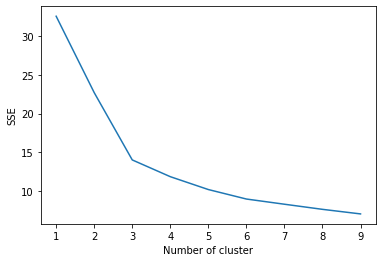

In [17]:
X = pd.DataFrame(data)
print(X)
data = X[[2, 3, 1]]

sse = {}
for k in range(1, 10):
    kmeans = cluster.KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()